# Análisis de los Ligandos cocristalizados

In [1]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


**Se genera la lista de archivos correspendiente a los ligandos cocristalizados**

In [194]:
import glob
path_crys_poses = "../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/"
files_pose_crys = sorted( glob.glob(path_crys_poses + "*") )
len(files_pose_crys)

365

In [195]:
# creamos un diccionario de estructura por ligando
pdb_lig_dict = {file.split("/")[-1].split("_")[0]: file.split("/")[-1].split("_")[1] for file in files_pose_crys}
pdb_lig_dict["1aq1"]

'STU'

### Se cargan las moléculas

In [196]:
# Cargamos los archivos en un diccionario u
ligs_cdk2_dic = {file.split("/")[-1].split("_")[0]: Chem.MolFromPDBFile(file) for file in files_pose_crys}

# Cargamos los ids ordenados en una lista
pdb_lig_array = np.array([file.split("/")[-1].split("_")[0] for file in files_pose_crys])

In [5]:
# comprobamos que todos los ligandos hayan sido cargados, si no es así se informará
for lig in ligs_cdk2_dic:
    if ligs_cdk2_dic[lig] is None:
        print(F'Error con el ligando {lig}')
print(F'Fin de la ejecución, {len(ligs_cdk2_dic)} moléculas cargadas.')

Fin de la ejecución, 365 moléculas cargadas.


## *Fingerprints*
**Se generan los fingerprints de cada molécula.**

In [6]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

In [7]:
# Se obtienen los fingerprints
mols = list(ligs_cdk2_dic.values()) # La lista de moléculas se obtiene del diccionario
fps_crys = [FingerprintMols.FingerprintMol(x) for x in mols] 
len(fps_crys)

365

### Comparación de los fingerprints usando el índice de Tanimoto

In [8]:
# Ejemplo de tanimoto
fp_1 = FingerprintMols.FingerprintMol(ligs_cdk2_dic["1aq1"])
fp_2 = FingerprintMols.FingerprintMol(ligs_cdk2_dic["1b38"])
# 
tan_1 = DataStructs.FingerprintSimilarity( fp_1, fp_2)
tan_2 = DataStructs.FingerprintSimilarity( fps_crys[0], fps_crys[1])
# Se comparan los fingerprints moléculas de ambos índices, los cuales tienen ATP
tan_1 == tan_2

True

In [9]:
# Se calcula el índice de Tanimoto entre ambos índices
fp_1 = FingerprintMols.FingerprintMol(ligs_cdk2_dic["1fin"]) # tiene ATP
fp_2 = FingerprintMols.FingerprintMol(ligs_cdk2_dic["1b38"]) # tiene ATP
DataStructs.FingerprintSimilarity( fp_1, fp_2)

1.0

2048

### Cálculo de la Matriz de Tanimoto

In [25]:
# Cálculo de la matriz de tanimoto
n_fps = len(fps_crys) # Número total de moléculas
tan_mtx = np.zeros((n_fps, n_fps)) # Matriz vacia de n * n
for  i  in  range(1, n_fps): # Se rellerna la matriz fila por fila
    sims  =  DataStructs.BulkTanimotoSimilarity( fps_crys[i], fps_crys[:] )
    tan_mtx[i] = sims

**Plot de la matriz de Tanimoto**

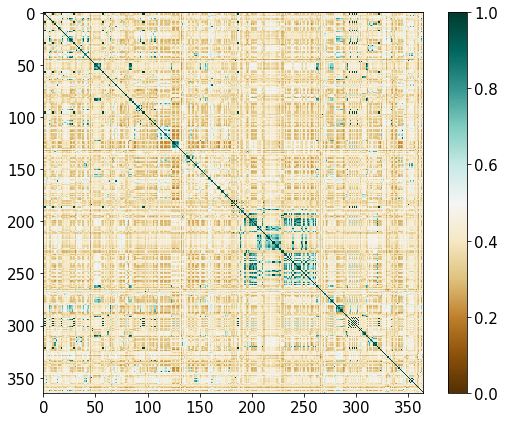

In [26]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 15})
plt.imshow(tan_mtx, cmap='BrBG')
plt.colorbar();

In [32]:
#Z.shape

(364, 4)

### Clustering utilizando el índice de Tanimoto


**_Clustering_ y dendograma generado utilizando _scipy_**

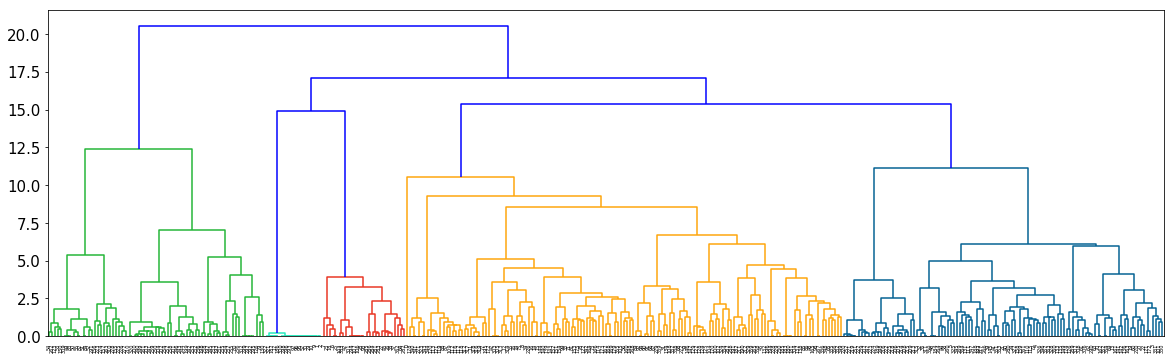

In [39]:
from scipy.cluster.hierarchy import ward, average, fcluster, dendrogram, set_link_color_palette
fig = plt.figure(figsize=(20, 6))
Z = ward( tan_mtx )

colores_ordenados = [ '#23B537',  '#23E9BC',  '#E93523', '#FEA50A', '#036193']

set_link_color_palette( colores_ordenados )
d = fcluster(Z , 0.9, criterion='distance')
clus = dendrogram(Z)

### cMDS y *Clustering* usando Sklearn

In [40]:
from modulos.MDS import cMDS
from modulos.plotting_functions import plot_mds_or_pca, plot_anotation_labels
mds_tan = cMDS( abs(tan_mtx - 1) )

Se importa sklearn.

In [41]:
from sklearn.cluster import AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit( abs(tan_mtx - 1) )

In [42]:
np.unique(clust.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 71, 143, 105,  27,  19]))

In [43]:
# Nombre del ligando más color de etiqueta
df_lig_colors = pd.DataFrame(pdb_lig_dict.items())
df_lig_colors["ColorLabel"] =  clust.labels_
df_lig_colors.columns = ["PDB_ID", "LIG", "ColorLabel"]
df_lig_colors.set_index('PDB_ID', inplace=True)
df_lig_colors.head(3).T


PDB_ID,1aq1,1b38,1b39
LIG,STU,ATP,ATP
ColorLabel,1,4,4


In [44]:
df_lig_colors[ df_lig_colors.ColorLabel == 4].T

PDB_ID,1b38,1b39,1fin,1fq1,1gy3,1hck,1jst,1qmz,2cch,2cci,2cjm,3qhr,3qhw,4eoj,4eom,4eoo,4eoq,4i3z,4ii5
LIG,ATP,ATP,ATP,ATP,ATP,ATP,ATP,ATP,ATP,ATP,ATP,ADP,ADP,ATP,ATP,ATP,ATP,ADP,ADP
ColorLabel,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


#### Guardamos el dataframe de etiquetas en un objeto json
El objetivo es utilizar dichas etiquetas, guardadas en el archivo *__.json__* para marcar las conformaciones según el grupo de logandos que poseen.

In [45]:
import json
# Primero convertimos a un diccionario
dic_to_save_ligs = df_lig_colors.to_dict()
json_ligs = json.dumps(dic_to_save_ligs)
f = open("./B_DATOS/dict_ligs_cristales_etiquetados_por_grupo_tanimoto.json","w")
f.write(json_ligs)
f.close()

Gráfica de cMDS con los ligandos coloreados por *cluster*. Se muestran las conformaciones de referencia. Recordar que el índice **3pxr** no tiene ligando por lo tanto no aparece en el gráfico.

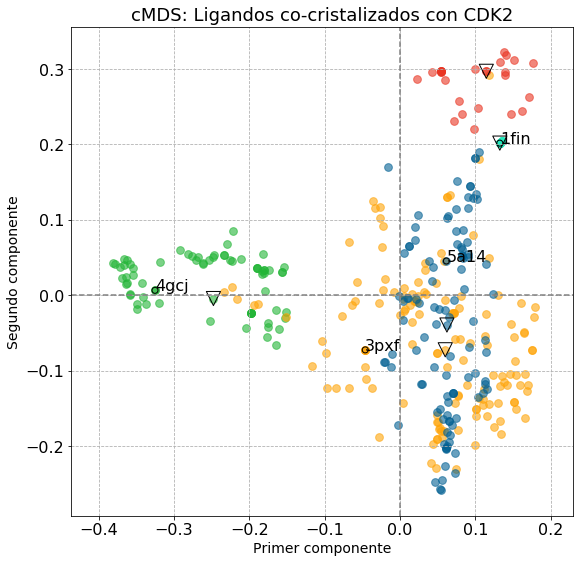

In [233]:
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "4gcj": "blue", "3pxf": "orange"}
centroids = {'4bck':'', '3ej1':'', '3bht':'', '1e1v':'', '1b38':''}
colores = [ '#23B537', '#FEA50A', '#036193', '#E93523', '#23E9BC']

fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = mds_tan[0], labels= clust.labels_, 
                colors_list= colores, title="cMDS: Ligandos co-cristalizados con CDK2")

# Anotaciones
for ref in ref_structs_dict:
    index = np.where(pdb_lig_array == ref)
    plt.annotate(ref, xy =(mds_tan[0][0][index], mds_tan[0][1][index]))
    plt.scatter(mds_tan[0][0][index], mds_tan[0][1][index], c="none", edgecolor='black')
    
for ref in centroids:
    index = np.where(pdb_lig_array == ref)
    plt.scatter(mds_tan[0][0][index], mds_tan[0][1][index], edgecolor='black', marker="v", s=200, color="none")

In [52]:
# Encontrar los centroides o moléculas representativas
df_lig_colors["mds1"] = mds_tan[0][0]
df_lig_colors["mds2"] = mds_tan[0][1]

In [209]:
# Grupo 1
med_1 = df_lig_colors.mds1[ df_lig_colors.ColorLabel == 3 ].mean()
med_2 = df_lig_colors.mds2[ df_lig_colors.ColorLabel == 3 ].mean()
cutoff = 0.023
a = (med_1 - cutoff < df_lig_colors.mds1) & (df_lig_colors.mds1 < med_1 + cutoff)
b = (med_2 - cutoff < df_lig_colors.mds2) & (df_lig_colors.mds2 < med_2 + cutoff)
df_lig_colors.index[ a & b]

# G0: 4bck
# G1: 3ej1
# G2: 3bht
# G3: 1e1v
# G4: 1b38

Index(['1e1v', '1gz8', '1h1p', '5ane'], dtype='object', name='PDB_ID')

In [145]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

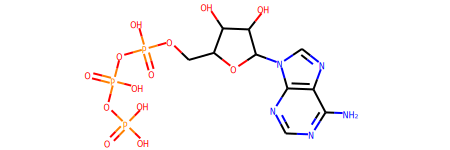

In [201]:
mol_1fin = Chem.MolFromSmiles('Nc1ncnc2n(cnc12)[C@@H]1O[C@H](CO[P@](O)(=O)O[P@@](O)(=O)OP(O)(O)=O)[C@@H](O)[C@H]1O')
SVG(moltosvg(mol_1fin))

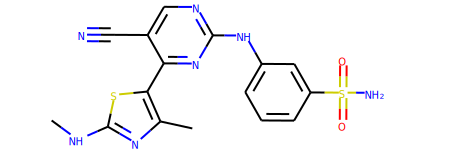

In [207]:
mol_1fin = Chem.MolFromSmiles('CNc1nc(C)c(s1)-c1nc(Nc2cccc(c2)S(N)(=O)=O)ncc1C#N')
SVG(moltosvg(mol_1fin))

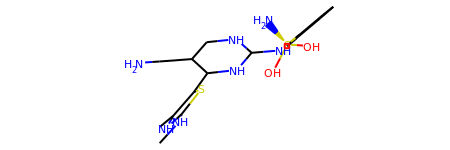

In [203]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

ligs_cdk2_dic["4bck"]

#### Vista en 3D

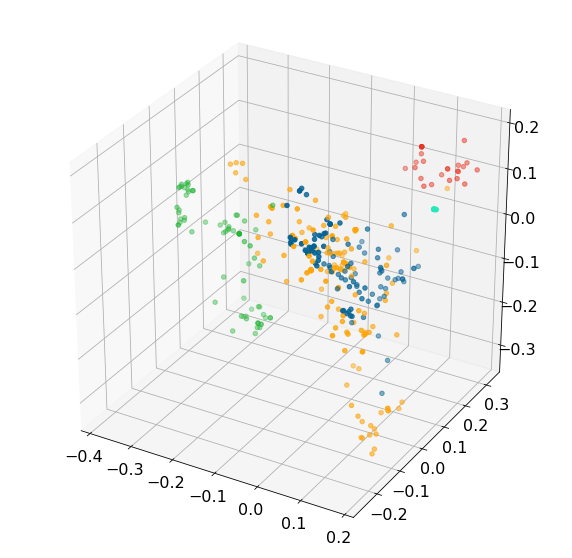

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(mds_tan[0][0], mds_tan[0][1], mds_tan[0][2], c=clust.labels_, cmap= colors.ListedColormap( colores ));

## Descriptores WHIM

In [22]:
len(Chem.rdMolDescriptors.CalcWHIM(mols[1]))

114

In [25]:
# Calculo manual de los descriptores WHIM
import pytraj as pyt
print(files_pose_crys[1])
print(files_pose_crys[2])
ATP_pdb_1 = pyt.load(files_pose_crys[1])
ATP_pdb_1.xyz
ATP_pdb_2 = pyt.load(files_pose_crys[2])
ATP_pdb_2.xyz

../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/1b38_ATP_LIG.pdb
../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/1b39_ATP_LIG.pdb


array([[[-15.932, 206.111, 120.574],
        [-17.026, 206.586, 121.431],
        [-16.184, 206.449, 119.151],
        ...,
        [ -9.665, 207.748, 110.316],
        [ -9.398, 207.516, 111.594],
        [-10.523, 207.129, 112.248]]])

In [41]:
# visualización de la molécula
import nglview
view = nglview.show_pytraj(ATP_pdb_1)  # load "3pqr" from RCSB PDB and display viewer widget
# two molecules
view.add_trajectory(ATP_pdb_2)
view


NGLWidget()

In [33]:
# Genero la matriz de covarianza de 3 x 3
cov_mtx = np.cov(ATP_pdb.xyz[0].T)
cov_mtx

array([[ 4.95437998,  1.01678768, -4.34717889],
       [ 1.01678768,  1.38803751, -1.43869312],
       [-4.34717889, -1.43869312, 12.9972429 ]])

In [34]:
# Matriz de covarianza manual
cov_mtx_manual = np.empty((3,3))
for q in range(3):
    media_q = np.mean( ATP_pdb.xyz[0].T[q] )
    center_q = ATP_pdb.xyz[0].T[q]  - media_q
    #print(center_p)
    for p in range(3):
        media_p = np.mean( ATP_pdb.xyz[0].T[p] )
        center_p = ATP_pdb.xyz[0].T[p]  - media_p
        # Calculo de qq
        A = np.sum(center_q*center_p) / 31
        cov_mtx_manual[p, q] = A
cov_mtx_manual

array([[ 4.79456127,  0.98398807, -4.20694732],
       [ 0.98398807,  1.34326211, -1.39228366],
       [-4.20694732, -1.39228366, 12.577977  ]])

In [35]:
# Se obtienen los eigenvalores
eigen_val, eigen_vec = np.linalg.eig(cov_mtx_manual)
eigen_val

array([14.62728943,  3.01695878,  1.07155217])

Descriptores p:
$$\theta_m = \frac{\lambda_m}{\sum_m \lambda_m}$$

In [36]:
# Descriptores P
eigen_val / sum(eigen_val)

array([0.78154763, 0.16119849, 0.05725388])

Descriptores E:
$$\eta_k = \frac{\lambda^2 \cdot nAT}{\sum_i t_i^4}$$

In [37]:
#Desciptores G
(eigen_val**2 * 31) / np.sum(ATP_pdb.xyz**4, axis=1)

array([[8.00885809e-03, 4.99332041e-09, 6.27700361e-09]])

In [38]:
np.sum(ATP_pdb.xyz[0].T**4)

62179658765.17204

In [40]:
Chem.rdMolDescriptors.CalcWHIM(mols[1])

[14.627,
 3.017,
 1.072,
 0.782,
 0.161,
 0.168,
 0.168,
 0.168,
 0.537,
 0.444,
 0.306,
 15.008,
 2.836,
 1.104,
 0.792,
 0.15,
 0.168,
 0.168,
 0.168,
 0.566,
 0.376,
 0.323,
 14.437,
 2.898,
 1.001,
 0.787,
 0.158,
 0.168,
 0.168,
 0.168,
 0.523,
 0.413,
 0.263,
 14.692,
 3.087,
 1.143,
 0.776,
 0.163,
 0.168,
 0.168,
 0.17,
 0.542,
 0.457,
 0.351,
 14.586,
 2.634,
 0.888,
 0.805,
 0.145,
 0.168,
 0.168,
 0.17,
 0.534,
 0.342,
 0.201,
 14.876,
 3.083,
 1.093,
 0.781,
 0.162,
 0.168,
 0.17,
 0.168,
 0.556,
 0.464,
 0.32,
 15.424,
 2.47,
 0.726,
 0.828,
 0.133,
 0.168,
 0.168,
 0.168,
 0.602,
 0.304,
 0.13,
 18.716,
 18.948,
 18.336,
 18.922,
 18.108,
 19.051,
 18.62,
 63.037,
 62.257,
 59.185,
 65.676,
 53.716,
 65.485,
 51.091,
 0.168,
 0.168,
 0.672,
 0.688,
 0.681,
 0.665,
 0.708,
 0.671,
 0.743,
 0.429,
 0.421,
 0.4,
 0.45,
 0.359,
 0.447,
 0.345,
 129.04,
 128.184,
 119.394,
 136.45,
 105.957,
 134.649,
 97.375]

In [34]:
dir(atp_1)

NameError: name 'atp_1' is not defined

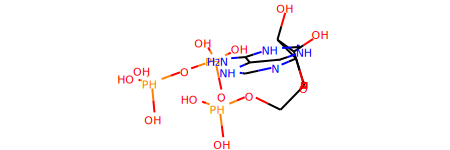

In [127]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')
from IPython.display import SVG
SVG(moltosvg(mols[1]))

In [ ]:
# Compute and plot dendrogram.
D = tan_mtx

fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
D = D[index,:]
D = D[:,index]
im = axmatrix.matshow(D, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

# Display and save figure.
fig.show()